[WARNING] Folder does not exist: ./frames\X38A
[WARNING] Folder does not exist: ./frames\X45T
[WARNING] Folder does not exist: ./frames\X49O
[WARNING] Folder does not exist: ./frames\X49P
[WARNING] Folder does not exist: ./frames\X57F
[WARNING] Folder does not exist: ./frames\X61S
[WARNING] Folder does not exist: ./frames\Y54Z
[WARNING] Folder does not exist: ./frames\Y65C
[WARNING] Folder does not exist: ./frames\Y78H
[WARNING] Folder does not exist: ./frames\Y99A
[WARNING] Folder does not exist: ./frames\Z01O
[WARNING] Folder does not exist: ./frames\Z13N
[WARNING] Folder does not exist: ./frames\Z28E
[WARNING] Folder does not exist: ./frames\Z30F
[WARNING] Folder does not exist: ./frames\Z33H
[WARNING] Folder does not exist: ./frames\Z49D
[WARNING] Folder does not exist: ./frames\Z49G
[WARNING] Folder does not exist: ./frames\Z49X
[WARNING] Folder does not exist: ./frames\Z62S
[WARNING] Folder does not exist: ./frames\X36T
[WARNING] Folder does not exist: ./frames\X63C
[WARNING] Fol

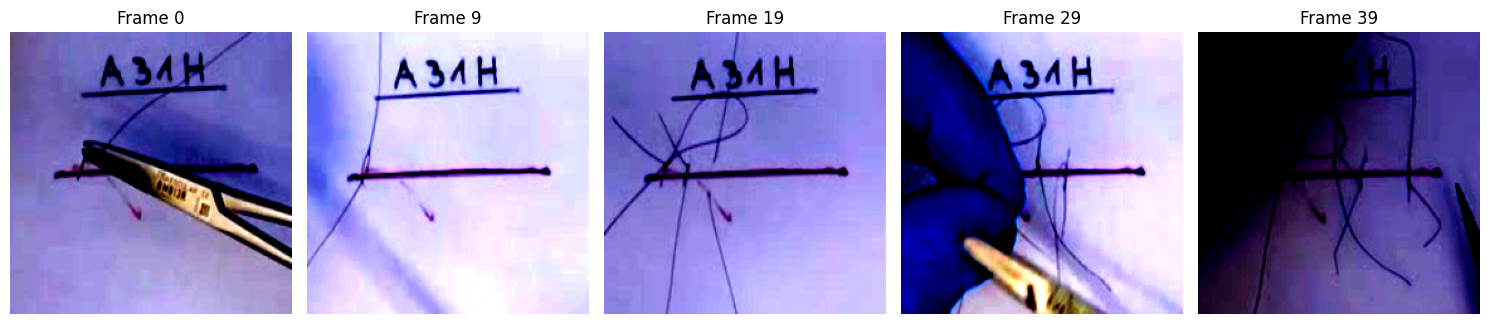

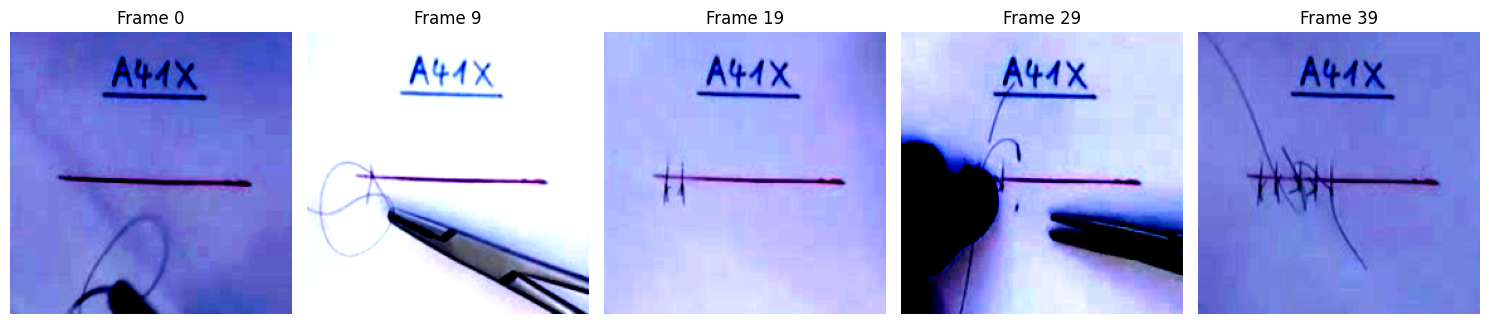

Batch shape: torch.Size([2, 40, 3, 224, 224])
=== Video: I58X ===


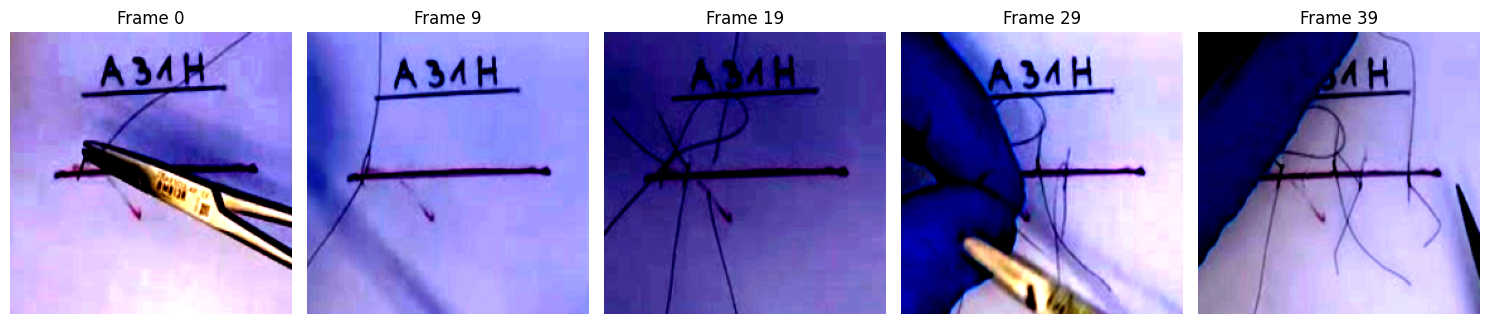

=== Video: L13Q ===


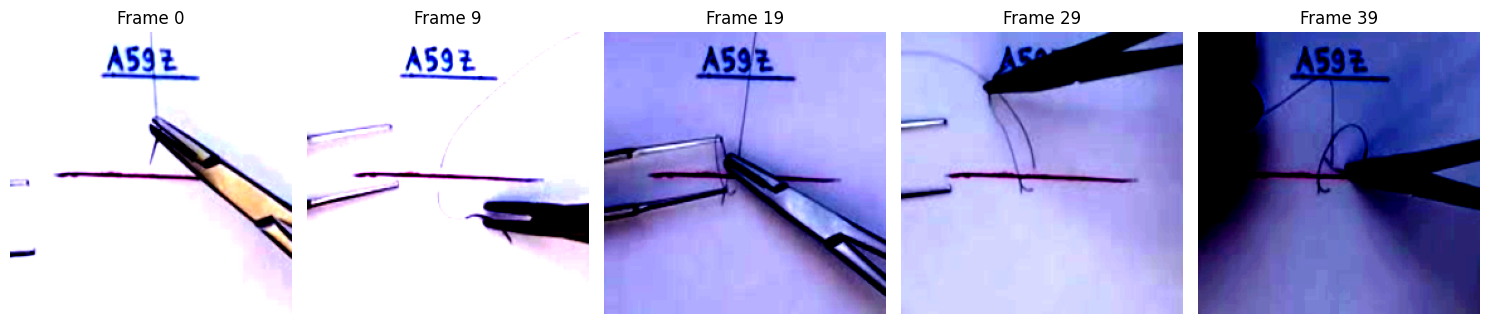

[TRAIN] Sample 0: parent folders = {'A31H'} | VID: A31H
[TRAIN] Sample 1: parent folders = {'A59Z'} | VID: A59Z
[TRAIN] Sample 2: parent folders = {'A83X'} | VID: A83X
[VAL] Sample 0: parent folders = {'A41X'} | VID: A41X
[VAL] Sample 1: parent folders = {'A66S'} | VID: A66S
[VAL] Sample 2: parent folders = {'B68G'} | VID: B68G
--- Starting epoch 1/100 ---
Validation loss decreased (inf --> 1.451090).  Saving model ...
Model saved!
Epoch 1 | trn_loss=1.621, trn_acc=0.271 | val_loss=1.451, val_acc=0.353
--- Starting epoch 2/100 ---


In [ ]:
# --- CELL 1: Imports & Config ---
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
from early_stopping_pytorch import EarlyStopping
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt

# CONFIG
FRAME_DIR    = "./frames"
EXCEL_FP     = "./data/OSATS_clean.xlsx"
TARGET_COLS  = [
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT",
    "OSATS_SUTURE", "OSATS_FLOW", "OSATS_KNOWLEDGE",
    "OSATS_PERFORMANCE", "OSATS_FINAL_QUALITY"
]
NUM_OUTPUTS   = len(TARGET_COLS)   # 8
NUM_CLASSES   = 5                  # Classes 1-5
BATCH_SIZE    = 2
LR            = 1e-4
EPOCHS        = 100
NUM_BLOCKS    = 8                  # How many windows per video
WINDOW_SEC    = 5                  # Seconds per window
FPS           = 1                  # Use your true FPS
NUM_WORKERS   = 0
PREFETCH_FACTOR = None
PERSISTENT_WORKERS = False
WEIGHT_DECAY  = 0.01
CLIP_NORM     = 1.0  # Gradient clipping norm

torch.backends.cudnn.benchmark = True

# --- CELL 2: Transforms & Glove Detection ---
frame_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.GaussianBlur(kernel_size=9, sigma=(0.5, 0.5)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def has_blue_glove_cv2(img, threshold=0.25):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([105, 30, 10])
    upper_blue = np.array([140, 200, 133])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    return (mask > 0).sum() / mask.size > threshold

# --- CELL 3: Dataset Definition (Multi-Block, Single-Video Safe) ---
class FrameClipDS(Dataset):
    def __init__(self, df, frame_dir=FRAME_DIR, transform=None, return_paths=False,
                 window_sec=5, fps=1, num_blocks=8):
        self.transform = transform
        self.return_paths = return_paths
        self.window_sec = window_sec
        self.fps = fps
        self.num_blocks = num_blocks
        self.num_frames_per_block = window_sec * fps
        self.samples = []
        for _, row in df.iterrows():
            vid = str(row.VIDEO)
            fdir = os.path.join(frame_dir, vid)
            # Check folder existence
            if not os.path.isdir(fdir):
                print(f"[WARNING] Folder does not exist: {fdir}")
                continue
            files = sorted(os.listdir(fdir))
            total = len(files)
            if total == 0:
                print(f"[WARNING] No frames in: {fdir}")
                continue
            block_size = total // num_blocks if num_blocks > 0 else total

            indices = []
            for b in range(num_blocks):
                block_start = b * block_size
                # Pick the start of block, or could randomize for augmentation
                offset = 0
                start = block_start + offset
                end = min(start + self.num_frames_per_block, (b+1)*block_size, total)
                block_indices = list(range(start, end))
                while len(block_indices) < self.num_frames_per_block:
                    block_indices.append(-1)
                indices.append(block_indices)
            flat_indices = [i for block in indices for i in block]
            paths = []
            for idx in flat_indices:
                if idx == -1:
                    paths.append(None)
                else:
                    paths.append(os.path.join(fdir, files[idx]))
            target = torch.from_numpy((row[TARGET_COLS].values - 1).astype(np.int64))
            self.samples.append((paths, target, vid))  # Add vid for debugging

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, target, vid = self.samples[idx]
        clips = []
        for p in paths:
            if p is None:
                img = np.zeros((256,256,3), np.uint8)
            else:
                img = cv2.imread(p)
                if img is None or has_blue_glove_cv2(img):
                    img = np.zeros((256,256,3), np.uint8)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if self.transform:
                img = self.transform(img)
            clips.append(img)
        clip_tensor = torch.stack(clips, dim=1).permute(1,0,2,3)
        target = target.unsqueeze(0).repeat(len(clips),1)
        if self.return_paths:
            return clip_tensor, target, paths, vid
        else:
            return clip_tensor, target

    def visualize_sample(self, idx, n=5):
        sample = self.__getitem__(idx)
        clip_tensor = sample[0]
        paths = sample[2] if self.return_paths else None
        T_frames = clip_tensor.shape[0]
        to_show = np.linspace(0, T_frames-1, min(n, T_frames), dtype=int)
        for i in to_show:
            img = clip_tensor[i].permute(1,2,0).cpu().numpy()
            img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            title = f"Frame {i}"
            if paths is not None and paths[i] is not None:
                title += f"\n{os.path.basename(paths[i])}"
            plt.title(title)
            plt.axis("off")
            plt.show()

# --- CELL 4: Model Definition ---

from torchvision.models import resnet18, ResNet18_Weights

class OSATSVideoResNetModel(nn.Module):
    def __init__(self, num_outputs=NUM_OUTPUTS, num_classes=NUM_CLASSES,
                 hidden_dim=128, lstm_layers=1, dropout_rate=0.5, bidirectional=True):
        super().__init__()
        self.num_outputs = num_outputs
        self.num_classes = num_classes
        self.base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.base.fc = nn.Identity()
        self.lstm = nn.LSTM(
            input_size=512, hidden_size=hidden_dim,
            num_layers=lstm_layers, batch_first=True,
            dropout=(dropout_rate if lstm_layers > 1 else 0),
            bidirectional=bidirectional
        )
        lstm_out = hidden_dim * (2 if bidirectional else 1)
        self.head = nn.Sequential(
            nn.Linear(lstm_out, 128),
            nn.ReLU(inplace=True),
            nn.LayerNorm(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_outputs * num_classes)
        )

    def forward(self, x):
        B, S, C, H, W = x.shape
        x = x.view(B * S, C, H, W)
        feats = self.base(x)            # [B*S, 512]
        feats = feats.view(B, S, -1)    # [B, S, 512]
        seq_out, _ = self.lstm(feats)
        out = self.head(seq_out)
        return out.view(B, S, self.num_outputs, self.num_classes)

# --- CELL 5: Data Loading & Split ---
df = pd.read_excel(EXCEL_FP)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for trn_idx, val_idx in msss.split(df, df[TARGET_COLS]):
    df_trn, df_val = df.iloc[trn_idx], df.iloc[val_idx]

train_ds = FrameClipDS(
    df_trn,
    transform=frame_transform,
    return_paths=True,
    num_blocks=NUM_BLOCKS,
    window_sec=WINDOW_SEC,
    fps=FPS
)
val_ds = FrameClipDS(
    df_val,
    transform=frame_transform,
    return_paths=True,
    num_blocks=NUM_BLOCKS,
    window_sec=WINDOW_SEC,
    fps=FPS
)

def show_transformed_batch(dataset, idx=0, n=5):
    """Visualize n frames from the idx-th sample in dataset after transforms."""
    sample = dataset[idx]
    clips = sample[0]  # [S, C, H, W]
    T_frames = clips.shape[0]
    to_show = np.linspace(0, T_frames-1, min(n, T_frames), dtype=int)
    fig, axs = plt.subplots(1, len(to_show), figsize=(15, 4))
    if len(to_show) == 1:
        axs = [axs]
    for j, i in enumerate(to_show):
        img = clips[i].permute(1,2,0).cpu().numpy()
        img = np.clip(img, 0, 1)
        axs[j].imshow(img)
        axs[j].set_title(f"Frame {i}")
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()

show_transformed_batch(train_ds, idx=0, n=5)
show_transformed_batch(val_ds, idx=0, n=5)

dl_trn = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR
)
dl_val = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR
)

xb, yb, paths, vid = next(iter(dl_trn))
print("Batch shape:", xb.shape)
for b in range(min(xb.size(0), 2)):  # Para os dois primeiros samples do batch
    print(f"=== Video: {vid[b]} ===")
    show_transformed_batch(train_ds, idx=b, n=5)


# --- Debug: Check folder safety ---
for i in range(3):  # check first few samples in train and val
    _, _, paths, vid = train_ds[i]
    parent_folders = set(os.path.basename(os.path.dirname(p)) for p in paths if p is not None)
    print(f"[TRAIN] Sample {i}: parent folders = {parent_folders} | VID: {vid}")
    if len(parent_folders) > 1:
        print("WARNING: Multiple folders in one sample!")
for i in range(3):
    _, _, paths, vid = val_ds[i]
    parent_folders = set(os.path.basename(os.path.dirname(p)) for p in paths if p is not None)
    print(f"[VAL] Sample {i}: parent folders = {parent_folders} | VID: {vid}")
    if len(parent_folders) > 1:
        print("WARNING: Multiple folders in one sample!")

# --- CELL 6: Instantiate Model ---
model = OSATSVideoResNetModel().cuda()

# --- CELL 7: Class Weights & Criterion ---
criterion_all = nn.CrossEntropyLoss()

# --- CELL 8: Optimizer, Scheduler, EarlyStopping, Writer ---
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              cooldown=2, min_lr=1e-6)
scaler = GradScaler(init_scale=2**12)
writer = SummaryWriter()

best_val_loss = float('inf')
early_stopper = EarlyStopping(patience=10, verbose=True)

# --- CELL 9: Training Loop ---
for epoch in range(EPOCHS):
    print(f"--- Starting epoch {epoch+1}/{EPOCHS} ---")

    # TRAIN
    model.train()
    total_loss, total_acc = 0.0, 0.0
    count = 0

    for xb, yb, _, _ in dl_trn:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            out = model(xb)
            loss = criterion_all(out.view(-1, NUM_CLASSES), yb.view(-1))
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(-1)
        acc = (preds == yb).float().mean().item()
        total_acc += acc * xb.size(0)
        count += xb.size(0)

    total_loss /= count
    total_acc /= count

    # VALIDATE
    model.eval()
    v_loss, v_acc, vcount = 0.0, 0.0, 0
    torch.cuda.empty_cache()

    with torch.no_grad():
        for xb, yb, _, _ in dl_val:
            xb, yb = xb.cuda(), yb.cuda()
            out = model(xb)
            loss = criterion_all(out.view(-1, NUM_CLASSES), yb.view(-1))
            v_loss += loss.item() * xb.size(0)
            preds = out.argmax(-1)
            acc = (preds == yb).float().mean().item()
            v_acc += acc * xb.size(0)
            vcount += xb.size(0)

    v_loss /= vcount
    v_acc /= vcount

    scheduler.step(v_loss)
    early_stopper(v_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), f"best_model_epoch{epoch+1}_val{v_loss:.4f}.pt")
        print("Model saved!")

    print(f"Epoch {epoch+1} | trn_loss={total_loss:.3f}, trn_acc={total_acc:.3f} | val_loss={v_loss:.3f}, val_acc={v_acc:.3f}")

    writer.add_scalar("Loss/train", total_loss, epoch)
    writer.add_scalar("Loss/val",   v_loss,      epoch)
    writer.add_scalar("Acc/train",  total_acc,   epoch)
    writer.add_scalar("Acc/val",    v_acc,       epoch)

writer.close()
